In [5]:
%pip install opencv-python numpy matplotlib seaborn scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\LENOVO\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [6]:
import os
import cv2  # OpenCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Agar grafik muncul di notebook
%matplotlib inline

print("Library berhasil di-import!")

#end

Library berhasil di-import!


In [7]:
# --- KONFIGURASI ---
DATASET_PATH = "dataset wajah2" # Pastikan path ini benar sesuai folder Anda (Dataset_Wajah atau dataset wajah2)
IMG_SIZE = 160  # Sesuai Janji di Laporan Bab 3.3

def load_dataset(path):
    data = []
    labels = []
    class_names = []
    
    # Cek folder
    if not os.path.exists(path):
        print(f"Error: Folder '{path}' tidak ditemukan!")
        print("Tips: Cek sidebar kiri VS Code, apa nama folder sebenarnya? (Huruf besar/kecil berpengaruh)")
        return np.array(data), np.array(labels), class_names

    print(f"Sedang memeriksa folder: {path} ...")

    for folder_name in os.listdir(path):
        folder_path = os.path.join(path, folder_name)

        if os.path.isdir(folder_path):
            class_names.append(folder_name)
            label_index = class_names.index(folder_name)
            print(f"--> Memproses kelas: {folder_name}")

            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                try:
                    # 1. Baca Citra
                    img_array = cv2.imread(img_path)
                    if img_array is None: continue 

                    # 2. Grayscaling (Sesuai Laporan)
                    gray_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)

                    # 3. Resizing (SUDAH AKTIF KEMBALI - SESUAI LAPORAN)
                    # Kita gunakan IMG_SIZE yang sudah di-set 64 di paling atas
                    resized_img = cv2.resize(gray_img, (IMG_SIZE, IMG_SIZE))

                    data.append(resized_img)
                    labels.append(label_index)

                except Exception as e:
                    pass

    data = np.array(data)
    labels = np.array(labels)
    
    print(f"\nSelesai! Total Data: {len(data)} citra.")
    
    # Validasi output untuk memastikan resize berhasil
    if len(data) > 0:
        print(f"Dimensi Citra: {data.shape[1]}x{data.shape[2]} (Sesuai Laporan)")
    
    return data, labels, class_names

# --- EKSEKUSI ---
data, labels, class_names = load_dataset(DATASET_PATH)

if len(data) > 0:
    print("Dataset siap digunakan untuk Training!")

Sedang memeriksa folder: dataset wajah2 ...
--> Memproses kelas: Brad Pitt
--> Memproses kelas: Camila Cabello
--> Memproses kelas: Claire Holt
--> Memproses kelas: Courtney Cox
--> Memproses kelas: daffa
--> Memproses kelas: Dwayne Johnson
--> Memproses kelas: Ellen Degeneres
--> Memproses kelas: Jessica Alba
--> Memproses kelas: Lisa Kudrow
--> Memproses kelas: Maheswara Ariq Athallah
--> Memproses kelas: Muhammad Al Qarnie

Selesai! Total Data: 550 citra.
Dimensi Citra: 160x160 (Sesuai Laporan)
Dataset siap digunakan untuk Training!


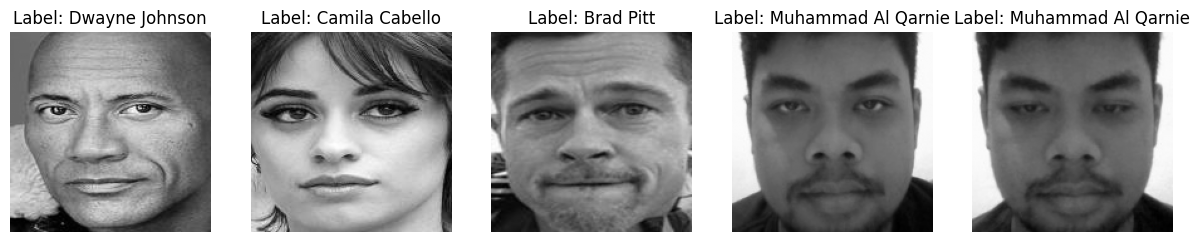

In [8]:
# Menampilkan 5 sampel acak
plt.figure(figsize=(15, 5))
for i in range(5):
    idx = np.random.randint(0, len(data))
    plt.subplot(1, 5, i+1)
    plt.imshow(data[idx], cmap='gray')
    plt.title(f"Label: {class_names[labels[idx]]}")
    plt.axis('off')
plt.show()

#end

In [9]:
# 1. Flattening: Mengubah (N, 64, 64) menjadi (N, 4096)
X = data.reshape(len(data), -1) # -1 otomatis menghitung 64*64
y = labels

print(f"Dimensi Data Sebelum Flatten: {data.shape}")
print(f"Dimensi Data Setelah Flatten: {X.shape} (Siap untuk KNN)")

# 2. Split Data (80% Latih, 20% Uji) - Skenario 2 Bab 4
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Jumlah Data Latih: {len(X_train)}")
print(f"Jumlah Data Uji: {len(X_test)}")

#end

Dimensi Data Sebelum Flatten: (550, 160, 160)
Dimensi Data Setelah Flatten: (550, 25600) (Siap untuk KNN)
Jumlah Data Latih: 440
Jumlah Data Uji: 110


Mulai Pengujian Nilai K...
------------------------------
|  Nilai K  |  Akurasi (80:20)  |
------------------------------
|    K=1    |     83.64%     |
|    K=3    |     73.64%     |
|    K=5    |     76.36%     |
|    K=7    |     73.64%     |
|    K=9    |     75.45%     |
------------------------------


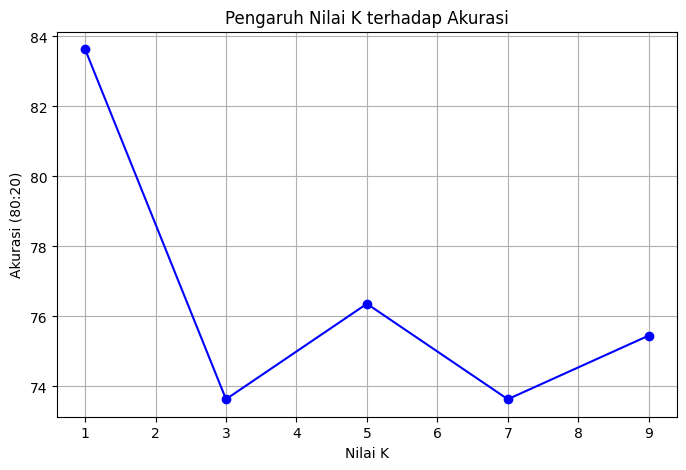

In [10]:
k_values = [1, 3, 5, 7, 9]
accuracies = []

print("Mulai Pengujian Nilai K...")
print("-" * 30)
print("|  Nilai K  |  Akurasi (80:20)  |")
print("-" * 30)

for k in k_values:
    # Membuat model KNN
    model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')

    # Melatih model
    model.fit(X_train, y_train)

    # Prediksi
    y_pred = model.predict(X_test)

    # Hitung akurasi
    acc = accuracy_score(y_test, y_pred) * 100
    accuracies.append(acc)

    print(f"|    K={k}    |     {acc:.2f}%     |")

print("-" * 30)

# Visualisasi Grafik (Elbow Method sederhana)
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
plt.title('Pengaruh Nilai K terhadap Akurasi')
plt.xlabel('Nilai K')
plt.ylabel('Akurasi (80:20)')
plt.grid(True)
plt.show()


#end


--- Laporan Klasifikasi (K=9) ---
                         precision    recall  f1-score   support

              Brad Pitt       0.50      0.80      0.62        10
         Camila Cabello       1.00      0.80      0.89        10
            Claire Holt       0.62      0.80      0.70        10
           Courtney Cox       0.86      0.60      0.71        10
                  daffa       1.00      1.00      1.00        10
         Dwayne Johnson       0.71      0.50      0.59        10
        Ellen Degeneres       0.64      0.70      0.67        10
           Jessica Alba       0.62      0.80      0.70        10
            Lisa Kudrow       0.60      0.30      0.40        10
Maheswara Ariq Athallah       1.00      1.00      1.00        10
     Muhammad Al Qarnie       1.00      1.00      1.00        10

               accuracy                           0.75       110
              macro avg       0.78      0.75      0.75       110
           weighted avg       0.78      0.75      0.7

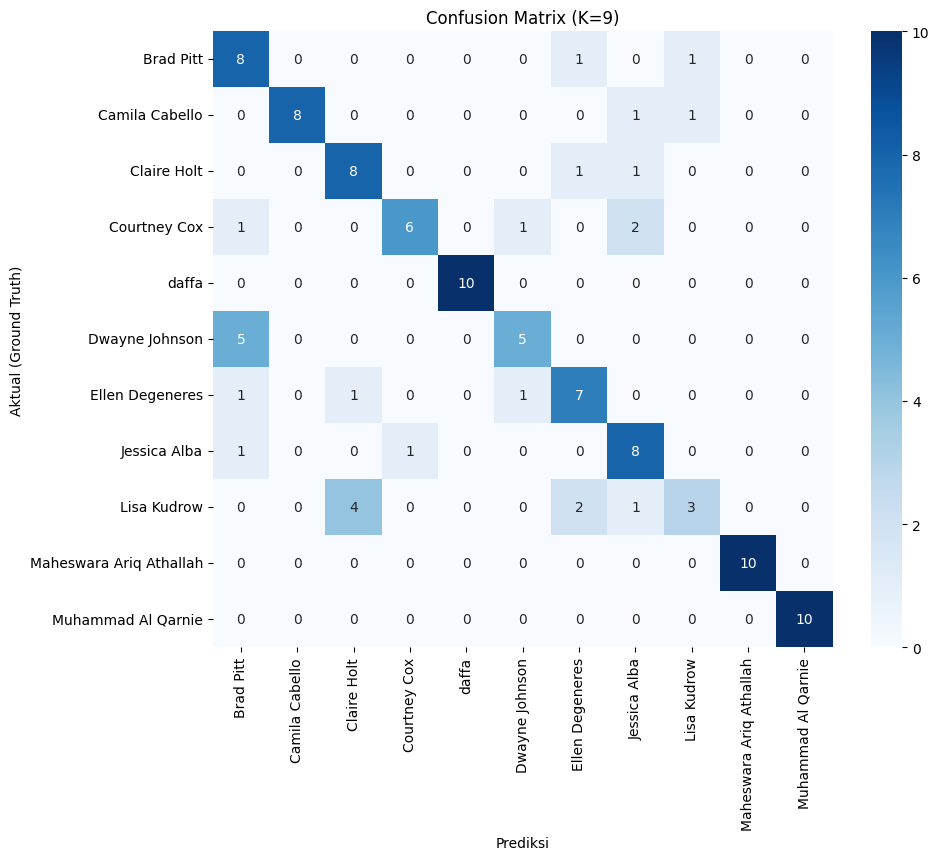

In [11]:
# Ambil K terbaik (misal K=3 berdasarkan grafik di atas)
BEST_K = 9
final_model = KNeighborsClassifier(n_neighbors=BEST_K, metric='euclidean')
final_model.fit(X_train, y_train)

# Prediksi Akhir
y_pred_final = final_model.predict(X_test)

# --- 1. CLASSIFICATION REPORT (Presisi, Recall, F1) ---
print(f"\n--- Laporan Klasifikasi (K={BEST_K}) ---")
print(classification_report(y_test, y_pred_final, target_names=class_names))

# --- 2. CONFUSION MATRIX (Gambar 4.1 di Laporan) ---
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediksi')
plt.ylabel('Aktual (Ground Truth)')
plt.title(f'Confusion Matrix (K={BEST_K})')
plt.show()

#end

Jarak terdekat: 2050.65
Sistem: Wajah Dikenali sebagai Maheswara Ariq Athallah


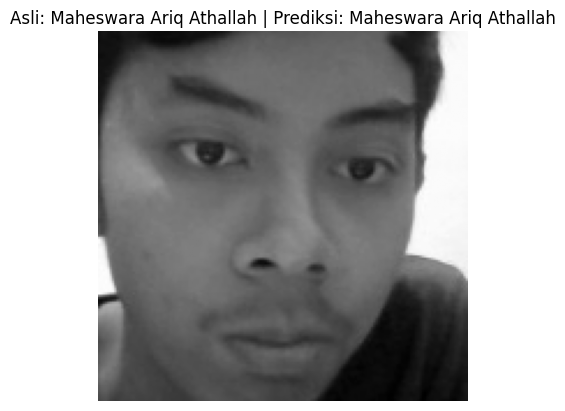

In [12]:
def simulasi_absensi(index_test):
    # Ambil satu gambar dari data uji
    img_test = X_test[index_test].reshape(1, -1) # Flatten ulang
    actual_label = class_names[y_test[index_test]]

    # Cari jarak ke tetangga terdekat (Logika Threshold di Flowchart)
    distances, indices = final_model.kneighbors(img_test)
    min_distance = distances[0][0] # Jarak terdekat

    # Tentukan Threshold (Misal 2000, sesuaikan dengan percobaan)
    THRESHOLD = 10000 # Angka ini harus disesuaikan saat run program
    
    print(f"Jarak terdekat: {min_distance:.2f}")

    if min_distance > THRESHOLD:
        print("Sistem: Wajah TIDAK Dikenali (Jarak terlalu jauh)")
        pred_label = "Unknown"
    else:
        pred_index = final_model.predict(img_test)[0]
        pred_label = class_names[pred_index]
        print(f"Sistem: Wajah Dikenali sebagai {pred_label}")

    # Tampilkan Gambar
    plt.imshow(X_test[index_test].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    plt.title(f"Asli: {actual_label} | Prediksi: {pred_label}")
    plt.axis('off')
    plt.show()

# Coba simulasi pada data ke-10 di set pengujian
simulasi_absensi(3)

#end

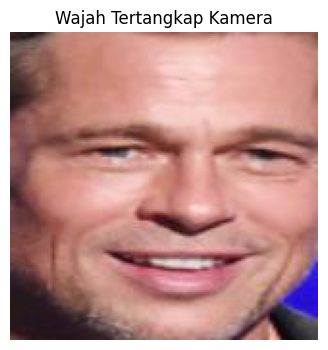


--- HASIL ANALISIS SISTEM ---
Jarak Kemiripan: 6041.10
🟢 Status: ABSEN BERHASIL!
👤 Identitas: Brad Pitt


In [13]:
# --- SIMULASI ABSENSI DENGAN FOTO EKSTERNAL (REAL-WORLD TEST) ---

def tes_foto_baru(path_file_gambar):
    """
    Fungsi ini mensimulasikan kamera menangkap wajah seseorang.
    Kita ambil file gambar dari luar dataset, lalu suruh AI menebak.
    """
    
    # 1. Cek apakah file ada
    if not os.path.exists(path_file_gambar):
        print(f"Error: File '{path_file_gambar}' tidak ditemukan!")
        return

    # 2. Baca Gambar
    img_real = cv2.imread(path_file_gambar)
    if img_real is None:
        print("Error: Gambar tidak bisa dibaca.")
        return
    
    # Tampilkan Gambar Asli
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB))
    plt.title("Wajah Tertangkap Kamera")
    plt.axis('off')
    plt.show()

    try:
        # 3. Pra-pemrosesan (Harus SAMA PERSIS dengan Training)
        # a. Grayscale
        gray_new = cv2.cvtColor(img_real, cv2.COLOR_BGR2GRAY)
        
        # b. Resize (WAJIB 160x160 sesuai model Anda)
        resized_new = cv2.resize(gray_new, (IMG_SIZE, IMG_SIZE))
        
        # c. Flatten (Jadi 1 baris)
        flat_new = resized_new.reshape(1, -1)

        # 4. Prediksi (KNN Magic)
        distances, indices = final_model.kneighbors(flat_new)
        min_dist = distances[0][0]
        
        # 5. Logika Absensi (Threshold)
        # Ingat: Karena size 160x160, jaraknya bakal besar (ribuan/puluhan ribu)
        # Sesuaikan THRESHOLD ini saat demo sampai pas.
        THRESHOLD_DEMO = 25000 
        
        print(f"\n--- HASIL ANALISIS SISTEM ---")
        print(f"Jarak Kemiripan: {min_dist:.2f}")
        
        if min_dist > THRESHOLD_DEMO:
            print("🔴 Status: WAJAH TIDAK DIKENALI (Orang Asing / Bukan Mahasiswa)")
        else:
            pred_index = final_model.predict(flat_new)[0]
            nama_prediksi = class_names[pred_index]
            print(f"🟢 Status: ABSEN BERHASIL!")
            print(f"👤 Identitas: {nama_prediksi}")
            
    except Exception as e:
        print(f"Terjadi kesalahan: {e}")

# --- CARA PAKAI SAAT DEMO ---
# 1. Siapkan 1 foto wajah teman (misal 'tes_wajah.jpg') di folder yang sama dengan kode ini.
# 2. Panggil fungsinya:
tes_foto_baru("Brad Pitt_118.jpg")


=== PENGUJIAN RASIO 70:30 ===
Data Latih: 385 citra
Data Uji  : 165 citra
----------------------------------------
|  Nilai K  |  Akurasi (70:30)  |
----------------------------------------
|    K=1    |     79.39%      |
|    K=3    |     75.15%      |
|    K=5    |     76.97%      |
|    K=7    |     75.76%      |
|    K=9    |     76.97%      |
----------------------------------------


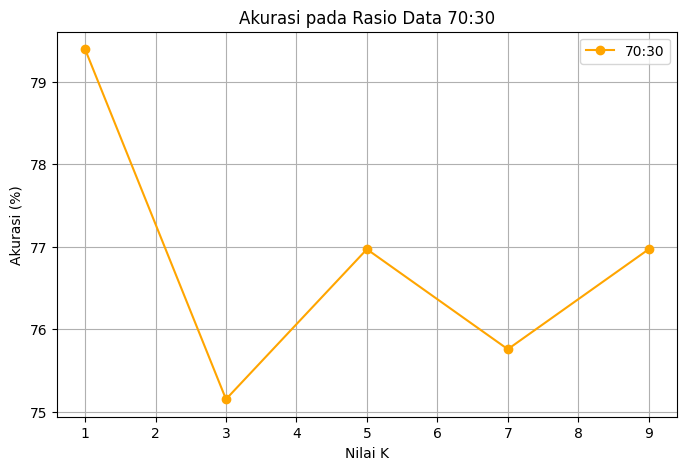

In [14]:
# --- SKENARIO 2.A: PENGUJIAN RASIO 70:30 ---
print("\n=== PENGUJIAN RASIO 70:30 ===")

# 1. Split Data (70% Latih, 30% Uji)
X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Data Latih: {len(X_train_70)} citra")
print(f"Data Uji  : {len(X_test_30)} citra")

k_values = [1, 3, 5, 7, 9]
accuracies_70 = [] # List untuk menyimpan nilai akurasi agar bisa di-plot

print("-" * 40)
print("|  Nilai K  |  Akurasi (70:30)  |")
print("-" * 40)

for k in k_values:
    model_70 = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    model_70.fit(X_train_70, y_train_70)
    y_pred_70 = model_70.predict(X_test_30)
    
    # Hitung akurasi
    acc = accuracy_score(y_test_30, y_pred_70) * 100
    accuracies_70.append(acc) # Simpan ke list

    print(f"|    K={k}    |     {acc:.2f}%      |")
print("-" * 40)

# --- VISUALISASI GRAFIK 70:30 ---
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies_70, marker='o', linestyle='-', color='orange', label='70:30')
plt.title('Akurasi pada Rasio Data 70:30')
plt.xlabel('Nilai K')
plt.ylabel('Akurasi (%)')
plt.grid(True)
plt.legend()
plt.show()


=== PENGUJIAN RASIO 90:10 ===
Data Latih: 495 citra
Data Uji  : 55 citra
----------------------------------------
|  Nilai K  |  Akurasi (90:10)  |
----------------------------------------
|    K=1    |     80.00%      |
|    K=3    |     72.73%      |
|    K=5    |     72.73%      |
|    K=7    |     67.27%      |
|    K=9    |     70.91%      |
----------------------------------------


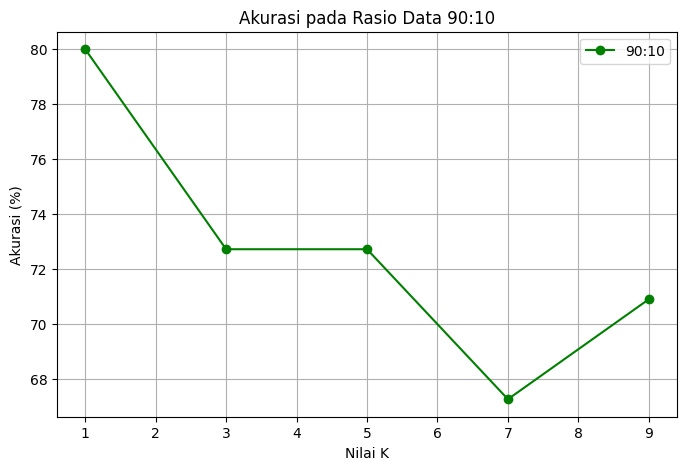

In [15]:
# --- SKENARIO 2.B: PENGUJIAN RASIO 90:10 ---
print("\n=== PENGUJIAN RASIO 90:10 ===")

# 1. Split Data (90% Latih, 10% Uji)
X_train_90, X_test_10, y_train_90, y_test_10 = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

print(f"Data Latih: {len(X_train_90)} citra")
print(f"Data Uji  : {len(X_test_10)} citra")

k_values = [1, 3, 5, 7, 9]
accuracies_90 = [] # List wajib ada untuk grafik

print("-" * 40)
print("|  Nilai K  |  Akurasi (90:10)  |")
print("-" * 40)

for k in k_values:
    model_90 = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    model_90.fit(X_train_90, y_train_90)
    y_pred_90 = model_90.predict(X_test_10)
    
    # Hitung akurasi
    acc = accuracy_score(y_test_10, y_pred_90) * 100
    accuracies_90.append(acc) # Simpan ke list

    print(f"|    K={k}    |     {acc:.2f}%      |")
print("-" * 40)

# --- VISUALISASI GRAFIK 90:10 ---
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies_90, marker='o', linestyle='-', color='green', label='90:10')
plt.title('Akurasi pada Rasio Data 90:10')
plt.xlabel('Nilai K')
plt.ylabel('Akurasi (%)')
plt.grid(True)
plt.legend()
plt.show()

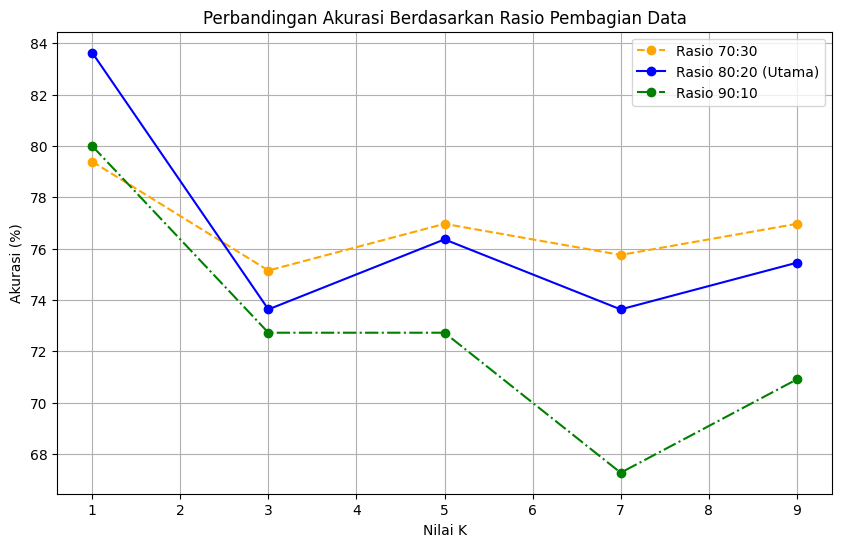

In [16]:
# --- WAJIB ADA BARIS INI DULU ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot Ketiga Garis
# Pastikan variabel accuracies_70, accuracies, dan accuracies_90 sudah ada isinya (sudah di-run sebelumnya)
plt.plot(k_values, accuracies_70, marker='o', linestyle='--', color='orange', label='Rasio 70:30')
plt.plot(k_values, accuracies,    marker='o', linestyle='-',  color='blue',   label='Rasio 80:20 (Utama)')
plt.plot(k_values, accuracies_90, marker='o', linestyle='-.', color='green',  label='Rasio 90:10')

plt.title('Perbandingan Akurasi Berdasarkan Rasio Pembagian Data')
plt.xlabel('Nilai K')
plt.ylabel('Akurasi (%)')
plt.grid(True)
plt.legend()
plt.show()

In [19]:
import cv2
import pandas as pd
from datetime import datetime
import os
import time  # Library wajib untuk hitung waktu

# Konfigurasi Waktu
DURASI_VALIDASI = 5  # Detik wajah harus stabil agar terabsen

# Load Detektor
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def absen_dengan_validasi_waktu():
    print(f"Membuka Kamera... Fitur Validasi {DURASI_VALIDASI} Detik AKTIF.")
    print("Tekan 'q' untuk simpan & keluar.")
    
    cap = cv2.VideoCapture(0)
    
    # Variabel Penyimpanan
    nama_sudah_absen = set()
    data_absensi = []
    
    # Dictionary untuk menyimpan 'Stopwatch' setiap orang
    # Format: {'Nama_Orang': waktu_mulai_terdeteksi}
    wajah_timers = {} 

    tanggal_hari_ini = datetime.now().strftime("%Y-%m-%d")
    nama_file_csv = f"Absensi_{tanggal_hari_ini}.csv"

    while True:
        ret, frame = cap.read()
        if not ret: break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(30, 30))

        # List nama yang terdeteksi di frame INI saja (untuk reset timer jika wajah hilang)
        nama_di_frame_ini = []

        for (x, y, w, h) in faces:
            wajah_crop = gray[y:y+h, x:x+w]
            
            try:
                # Resize & Prediksi
                wajah_resize = cv2.resize(wajah_crop, (IMG_SIZE, IMG_SIZE))
                wajah_flat = wajah_resize.reshape(1, -1)
                
                distances, indices = final_model.kneighbors(wajah_flat)
                min_dist = distances[0][0]
                
                # Threshold (Sesuaikan)
                if min_dist > 25000:
                    nama = "Unknown"
                    warna = (0, 0, 255) # Merah
                else:
                    pred_idx = final_model.predict(wajah_flat)[0]
                    nama = class_names[pred_idx]
                    warna = (0, 255, 255) # Kuning (Proses Verifikasi)

                # --- LOGIKA VALIDASI 5 DETIK ---
                if nama != "Unknown":
                    nama_di_frame_ini.append(nama)
                    
                    # 1. Jika orang ini belum ada di timer, nyalakan stopwatch
                    if nama not in wajah_timers:
                        wajah_timers[nama] = time.time()
                    
                    # 2. Hitung sudah berapa lama wajah ini nongol
                    durasi_sekarang = time.time() - wajah_timers[nama]
                    sisa_waktu = DURASI_VALIDASI - durasi_sekarang
                    
                    # 3. Cek Status Absen
                    if nama in nama_sudah_absen:
                        # Jika sudah absen sebelumnya
                        pesan_status = "SUDAH ABSEN"
                        warna = (0, 255, 0) # Hijau Solid
                        bar_progress = 1.0 # Penuh
                        
                    elif durasi_sekarang >= DURASI_VALIDASI:
                        # --- DETIK KE-5 TERCAPAI: CATAT ABSEN! ---
                        waktu_masuk = datetime.now().strftime("%H:%M:%S")
                        nama_sudah_absen.add(nama)
                        data_absensi.append({
                            'Nama': nama,
                            'Waktu Masuk': waktu_masuk,
                            'Status': 'Hadir (Terverifikasi)'
                        })
                        print(f"✅ [VALID] {nama} berhasil absen pukul {waktu_masuk}")
                        pesan_status = "BERHASIL!"
                        warna = (0, 255, 0) # Hijau Jadi
                        bar_progress = 1.0
                        
                    else:
                        # --- PROSES MENUNGGU (0 - 4.9 Detik) ---
                        pesan_status = f"Tahan... {sisa_waktu:.1f}s"
                        warna = (0, 255, 255) # Kuning
                        bar_progress = durasi_sekarang / DURASI_VALIDASI

                    # --- VISUALISASI ---
                    # Gambar Kotak Wajah
                    cv2.rectangle(frame, (x, y), (x+w, y+h), warna, 2)
                    
                    # Gambar Loading Bar di atas kepala
                    bar_width = int(w * bar_progress)
                    cv2.rectangle(frame, (x, y-15), (x + bar_width, y-5), warna, -1) # Bar isi
                    cv2.rectangle(frame, (x, y-15), (x + w, y-5), (255, 255, 255), 1) # Border bar
                    
                    # Tulis Nama
                    cv2.putText(frame, f"{nama}", (x, y+h+25), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, warna, 2)
                    # Tulis Status (Tahan... / Berhasil)
                    cv2.putText(frame, pesan_status, (x, y+h+50), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
                
                else:
                    # Jika Unknown
                    cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)
                    cv2.putText(frame, "Unknown", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

            except Exception as e:
                pass

        # --- RESET TIMER JIKA WAJAH HILANG ---
        # Cek semua timer yang sedang berjalan
        # Jika nama ada di timer TAPI tidak muncul di frame ini, hapus timernya.
        for nama_timer in list(wajah_timers.keys()):
            if nama_timer not in nama_di_frame_ini:
                # Kecuali kalau dia sudah absen, biarkan saja (opsional)
                if nama_timer not in nama_sudah_absen:
                    del wajah_timers[nama_timer]
        
        # Info Layar
        cv2.putText(frame, f"Total Hadir: {len(nama_sudah_absen)}", (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.imshow('Sistem Absensi + Validasi (Tekan q Keluar)', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    # Simpan CSV
    if len(data_absensi) > 0:
        df = pd.DataFrame(data_absensi)
        if os.path.exists(nama_file_csv):
            df.to_csv(nama_file_csv, mode='a', header=False, index=False)
        else:
            df.to_csv(nama_file_csv, index=False)
        print("\n--- Data Absensi Tersimpan ---")
        print(df)

# Jalankan
absen_dengan_validasi_waktu()

Membuka Kamera... Fitur Validasi 5 Detik AKTIF.
Tekan 'q' untuk simpan & keluar.
✅ [VALID] Muhammad Al Qarnie berhasil absen pukul 00:38:37

--- Data Absensi Tersimpan ---
                 Nama Waktu Masuk                 Status
0  Muhammad Al Qarnie    00:38:37  Hadir (Terverifikasi)


In [18]:
import cv2
import os
import time

# --- KONFIGURASI ---
DATASET_DIR = "dataset wajah2"  # Folder utama
IMG_SIZE = 160                  # Wajib 160x160
MAX_PHOTOS = 50                 # Target jumlah foto
JEDA_WAKTU = 0.5                # Jeda antar foto (detik)

# Load Detektor Wajah
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def ambil_foto_otomatis():
    # 1. Input Nama
    nama_user = input("Masukkan Nama Anda (untuk Label Folder): ").strip()
    
    # Buat folder
    save_path = os.path.join(DATASET_DIR, nama_user)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    # 2. Buka Kamera
    cap = cv2.VideoCapture(0)
    
    print(f"\n--- MODE OTOMATIS AKTIF ---")
    print(f"Sistem akan mengambil foto setiap {JEDA_WAKTU} detik.")
    print("Silakan gerakkan wajah Anda perlahan (kiri, kanan, senyum).")
    print("Tekan 'q' jika ingin berhenti paksa.\n")
    
    # Beri waktu persiapan 3 detik sebelum mulai
    print("Mulai dalam 3...")
    time.sleep(1)
    print("2...")
    time.sleep(1)
    print("1...")
    time.sleep(1)
    print("MULAI!\n")
    
    count = 0
    waktu_terakhir_ambil = time.time()
    
    while count < MAX_PHOTOS:
        ret, frame = cap.read()
        if not ret: break
        
        display_frame = frame.copy()
        
        # Deteksi Wajah
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(30, 30))
        
        # Cek Waktu (Agar tidak terlalu cepat brrrrt)
        waktu_sekarang = time.time()
        siap_ambil = (waktu_sekarang - waktu_terakhir_ambil) > JEDA_WAKTU
        
        for (x, y, w, h) in faces:
            # Gambar kotak
            if siap_ambil:
                warna = (0, 255, 0) # Hijau (Saat menjepret)
            else:
                warna = (255, 0, 0) # Biru (Menunggu jeda)
                
            cv2.rectangle(display_frame, (x, y), (x+w, y+h), warna, 2)
            
            # --- LOGIKA SIMPAN OTOMATIS ---
            if siap_ambil:
                # Proses Gambar
                wajah_crop = gray[y:y+h, x:x+w]
                wajah_resize = cv2.resize(wajah_crop, (IMG_SIZE, IMG_SIZE))
                
                # Simpan
                filename = f"{nama_user}_{count+1}.jpg"
                file_path = os.path.join(save_path, filename)
                cv2.imwrite(file_path, wajah_resize)
                
                count += 1
                print(f"📸 Cekrek! ({count}/{MAX_PHOTOS})")
                
                # Reset waktu timer
                waktu_terakhir_ambil = time.time()
                
                # Efek visual 'flash' di layar (opsional)
                cv2.putText(display_frame, "SAVED!", (x, y-10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

        # Tampilkan Info 
        cv2.putText(display_frame, f"Progress: {count}/{MAX_PHOTOS}", (10, 50), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
        
        cv2.imshow("Auto Capture (q untuk stop)", display_frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    
    if count >= MAX_PHOTOS:
        print(f"\n✅ SELESAI! 50 Foto wajah {nama_user} tersimpan.")
        print("Jangan lupa Run ulang bagian 'Load Dataset' & 'Training'!")

# Jalankan
ambil_foto_otomatis()


--- MODE OTOMATIS AKTIF ---
Sistem akan mengambil foto setiap 0.5 detik.
Silakan gerakkan wajah Anda perlahan (kiri, kanan, senyum).
Tekan 'q' jika ingin berhenti paksa.

Mulai dalam 3...
2...
1...
MULAI!

📸 Cekrek! (1/50)
📸 Cekrek! (2/50)
📸 Cekrek! (3/50)
📸 Cekrek! (4/50)
